# Simple double pendulum using Lagrange's equation

Defines a LagrangianDoublePendulum class that is used to generate basic double pendulum plots from solving Lagrange's equations. Based of the Langraian_pendulum notebook and LagrangianPendulum class both by Dick Furhstahl (furnstahl.1@osu.edu).

## Euler-Lagrange equation

For a simple double pendulum, the Lagrangian with generalized coordinates $\phi_1$ and $\phi_2$ is

$\begin{align}
  \mathcal{L} = \frac12 (m_1 + m_2) L_1^2 \dot\phi_1^2 + m_2 L_1 L_2 \dot\phi_1 \dot\phi_2 \cos(\phi_1 - \phi_2) + \frac12 m_2 L_2^2 \dot\phi_2^2 - (m_1 +m_2) g L_1 (1 - \cos\phi_1) - m_2 g L_2 (1- \cos\phi_2)
\end{align}$

The Euler-Lagrange equations are:

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad
 (m_1+m_2) L_1^2 \ddot \phi_1 + m_2L_1L_2 \ddot \phi_2 \cos(\phi_1 - \phi_2) + m_2L_1L_2 \dot \phi_2^2 \sin(\phi_1-\phi_2)= -(m_1+m_2)gL_1\sin\phi_1
  \;
\end{align}$

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad
 m_2 L_2^2 \ddot \phi_2 + m_2L_1L_2 \ddot \phi_1 \cos(\phi_1 - \phi_2) - m_2L_1L_2 \dot \phi_1^2 \sin(\phi_1-\phi_2)= -m_2gL_2\sin\phi_2
  \;
\end{align}$

You can solve that set of equations for $\ddot \phi_1$ and $\ddot \phi_2$ :

$\begin{align}
 \ddot \phi_1= \frac {-m_2 \dot \phi_1^2 \sin(\phi_1 - \phi_2)\cos(\phi_1 - \phi_2) +m_2(\frac {g}{L_1})\cos(\phi_1-\phi_2) \sin(\phi_2)- m_2(\frac {L_2}{L_1}) \dot \phi_2^2 \sin(\phi_1-\phi_2) -(m_1+m_2)(\frac {g}{L_1})\sin(\phi_1)}{ (m_1+m_2-m_2 \cos^2(\phi_1 -\phi_2))}
  \;
\end{align}$

$\begin{align}
 \ddot \phi_2= \frac {(\frac{m_2}{m_1+m_2}) \dot \phi_2^2 \sin(\phi_1 - \phi_2)\cos(\phi_1 - \phi_2) +(\frac {g}{L_2})\cos(\phi_1-\phi_2) \sin(\phi_1)+(\frac {L_1}{L_2}) \dot \phi_1^2 \sin(\phi_1-\phi_2) -(\frac {g}{L_2})\sin(\phi_2)}{ (1- \frac{m_2}{m_1+m_2} \cos^2(\phi_1 -\phi_2))}
  \;
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Double pendulum class and utility functions

In [4]:
class LagrangianDoublePendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a simple double pendulum (no driving or damping).
     
    Parameters
    ----------
    L_1 : float
        length of the first (grounded) pendulum arm
    L_2 : float
        length of the second pendulum arm
    g : float
        gravitational acceleration at the earth's surface
    m_1 : float
        mass at end of first arm
    m_2 : float
        mass at end of second arm

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L_1=1., m_1=1., L_2=2., m_2=2., g=1.
                ):
        self.L_1 = L_1
        self.L_2 = L_2
        self.g = g
        self.m_1 = m_1
        self.m_2 = m_2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi_1/dt d^2phi_1/dt^2 dphi_2/dt d^2phi_2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 2-component vector with y[0] = phi_1(t) and y[1] = dphi_1/dt y[2] = phi_2(t) and y[3] = dphi_2/dt
            
        Returns
        -------
        
        """
        #Introduce some short hand to simply the equations for both phi double dots
        c = np.cos(y[0]-y[2])
        s = np.sin(y[0]-y[2])
        M = self.m_1 + self.m_2
        Num_1 = -self.m_2* y[1]**2 *s*c + self.m_2*(self.g/self.L_1)*c*np.sin(y[2]) \
                - self.m_2*(self.L_2/self.L_1)* y[3]**2 *s - M*(self.g/self.L_1)*np.sin(y[0])
        
        Num_2 = (self.m_2/M)* y[3]**2 *s*c + (self.g/self.L_2)*c*np.sin(y[0]) \
                + (self.L_1/self.L_2)* y[1]**2 *s - (self.g/self.L_2)*np.sin(y[2])
        
        return [y[1], Num_1/(M - self.m_2* c**2), y[3],  Num_2/(1 - (self.m_2/M)* c**2)]
    
    def solve_ode(self, t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0,
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_1_dot, phi_2, phi_2_dot = solution.y

        return phi_1, phi_1_dot, phi_2,phi_2_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [7]:
# Labels for individual plot axes
phi_1_vs_time_labels = (r'$t$', r'$\phi_1(t)$')
phi_1_dot_vs_time_labels = (r'$t$', r'$d\phi_1/dt(t)$')
state_space_1_labels = (r'$\phi_1$', r'$d\phi_1/dt$')

phi_2_vs_time_labels = (r'$t$', r'$\phi_2(t)$')
phi_2_dot_vs_time_labels = (r'$t$', r'$d\phi_2/dt(t)$')
state_space_2_labels = (r'$\phi_2$', r'$d\phi_2/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L_1 = 1.
L_2 = 4.
g = 1.
mass_1 = 1.
mass_2 = 4.

# Instantiate a pendulum 
p1 = LagrangianDoublePendulum(L_1=L_1, m_1=mass_1, L_2=L_2, m_2=mass_2,g=g)
p2 = LagrangianDoublePendulum(L_1=L_1, m_1=mass_1, L_2=L_2, m_2=mass_2,g=g)

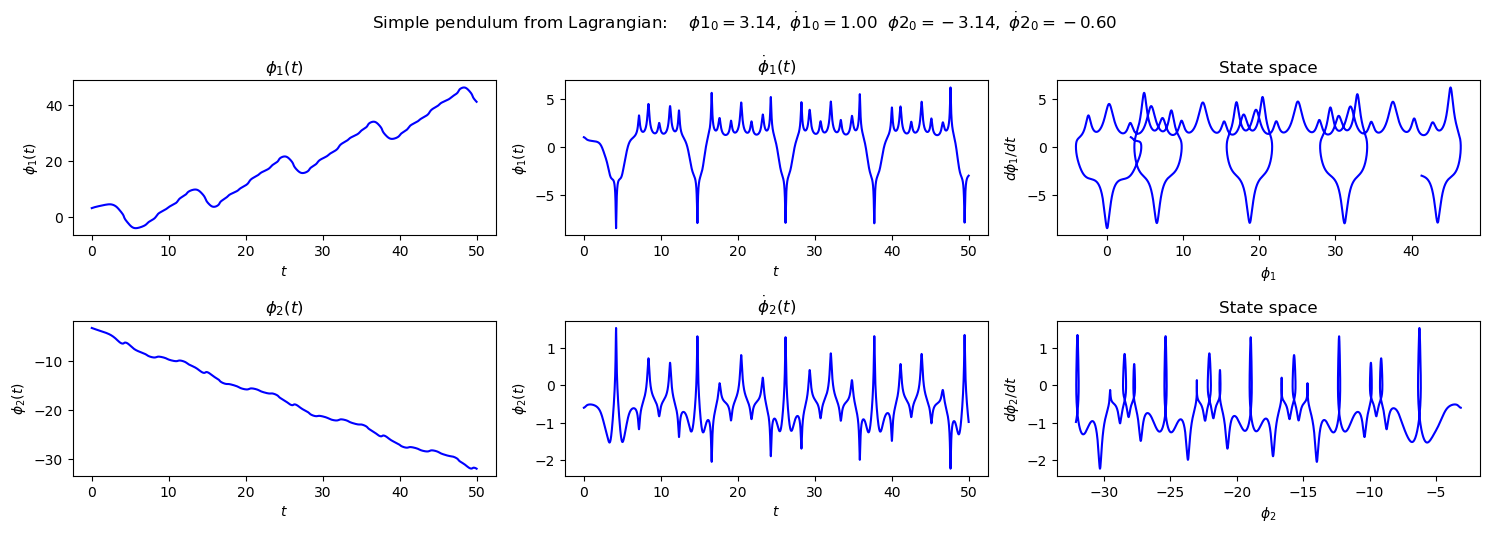

In [8]:
# both plots: same initial conditions
phi_1_0 = np.pi
phi_1_dot_0 = 1.
phi_2_0 = -np.pi
phi_2_dot_0 = -.6

offset = .00001

#In order to tell the two different solutions apart, pendulum two will use capital Phi
phi_1, phi_1_dot, phi_2, phi_2_dot = p1.solve_ode(t_pts, phi_1_0, phi_1_dot_0, phi_2_0, phi_2_dot_0)
Phi_1, Phi_1_dot, Phi_2, Phi_2_dot = p2.solve_ode(t_pts, phi_1_0+offset, phi_1_dot_0, phi_2_0, phi_2_dot_0)

# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Simple pendulum from Lagrangian:  ' + \
                rf'  $\phi 1_0 = {phi_1_0:.2f},$' + \
                rf' $\dot\phi 1_0 = {phi_1_dot_0:.2f}$' + \
                rf'  $\phi 2_0 = {phi_2_0:.2f},$' + \
                rf' $\dot\phi 2_0 = {phi_2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(2,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\phi_1(t)$', 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(2,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1_dot[start : stop], 
            axis_labels=phi_1_vs_time_labels, 
            color='blue',
            label=None, 
            title=r'$\dot\phi_1(t)$', 
            ax=ax_b)    

# third plot: phi_1 state space plot from t=30 to t=50   
ax_c = fig.add_subplot(2,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi_1[start : stop], phi_1_dot[start : stop], 
            axis_labels=state_space_1_labels, 
            color='blue',
            label=None, 
            title='State space', 
            ax=ax_c)    

# fourth plot: phi_2 plot
ax_d = fig.add_subplot(2,3,4)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\phi_2(t)$', 
            ax=ax_d)    
                              
# second plot: phi_2_dot plot 
ax_e = fig.add_subplot(2,3,5)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_2_dot[start : stop], 
            axis_labels=phi_2_vs_time_labels, 
            color='red',
            label=None, 
            title=r'$\dot\phi_2(t)$', 
            ax=ax_e)    

# third plot: phi_2 state space plot from t=30 to t=50   
ax_f = fig.add_subplot(2,3,6)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi_2[start : stop], phi_2_dot[start : stop], 
            axis_labels=state_space_2_labels, 
            color='red',
            label=None, 
            title='State space', 
            ax=ax_f)  

fig.tight_layout()
fig.savefig('simple_double_pendulum_Lagrange.png', bbox_inches='tight')  

## Investigation of Chaos 

First we'll look at the power spectrum. Chaos would be evident here if the spectrum is continuous, instead of just peaking at a finite number of frequencies.

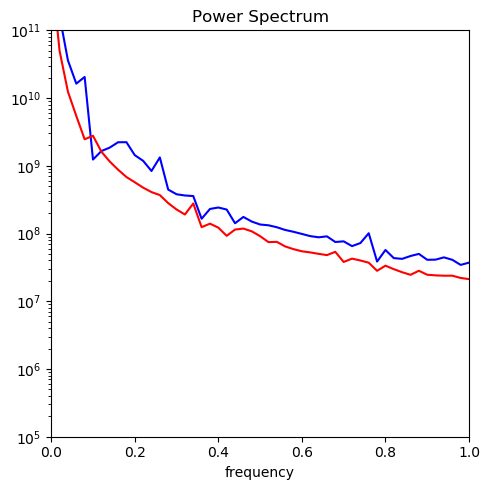

In [9]:
start, stop = start_stop_indices(t_pts, t_start, t_end)

signal_1 = phi_1[start:stop]
power_spectrum_1 = np.abs(np.fft.fft(signal_1))**2
freqs_1 = np.fft.fftfreq(signal_1.size, delta_t)
idx_1 = np.argsort(freqs_1)

signal_2 = phi_2[start:stop]
power_spectrum_2 = np.abs(np.fft.fft(signal_2))**2
freqs_2 = np.fft.fftfreq(signal_2.size, delta_t)
idx_2 = np.argsort(freqs_2)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs_1[idx_1], power_spectrum_1[idx_1], color='blue')
ax_ps.semilogy(freqs_2[idx_2], power_spectrum_2[idx_2], color='red')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e5, 1.e11)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')

fig_ps.tight_layout()

The spectra above are definitely continuous. That is one potential sign of chaos in the full double pendulum solution.

Chaotic systems are also very sensitive to their initial conditions. Two similar sets of initial conditions should have solutions that diverge exponentially.

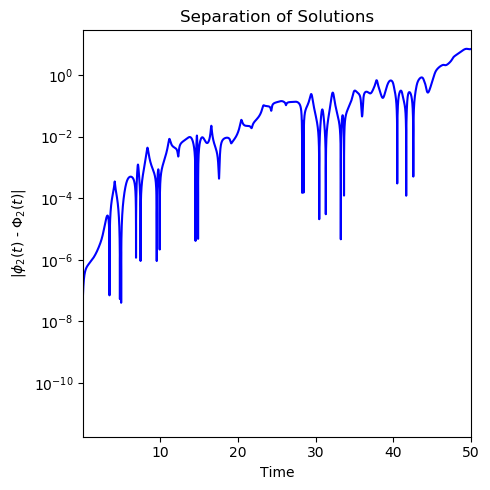

In [11]:
#In order to observe any sensitivity to initial conditions the phi_2 and theta_2 will be compared

delta_phi_2 = abs(phi_2 - Phi_2)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(t_pts, delta_phi_2, color='blue')
ax_ps.set_xlim(0.1, 50.)
ax_ps.set_xlabel('Time')
ax_ps.set_ylabel('|$\phi_2(t)$ - $\Phi_2(t)$|')
ax_ps.set_title('Separation of Solutions')

fig_ps.tight_layout()

The plot above shows a linearly increasing trend in the separation between the solutions on the logarithmic scale. That means that the two solutions are diverging exponentially. 